# Binary Neural Network (BNN) for Plant Disease Classification

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification. The BNN uses binary weights and activations to reduce model size and computational requirements while maintaining reasonable accuracy.

## Features:
- Binary weights and activations using sign function
- Processes 128x128 RGB images (3×128×128 input) with memory-efficient loading
- One hidden layer with binary weights
- Multiclass output with softmax activation
- CrossEntropyLoss for training
- Memory-efficient data loading to prevent system hangs

## Memory Optimizations:
- Images loaded on-demand during training (not all at once)
- Reduced batch size for 128x128 images
- Multi-worker data loading for better performance
- Efficient train/test splitting without loading full dataset

In [1]:
# Import Required Libraries
%pip install torch torchvision matplotlib numpy pandas seaborn scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Using device: cuda
Using device: cuda


In [2]:
# Additional imports for enhanced visualization and data export
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import time
import datetime
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)
print("Results directory created: ./results/")

Results directory created: ./results/


In [3]:
# Binary Activation Function
class BinaryActivation(torch.autograd.Function):
    """
    Binary activation function using the sign function.
    Forward: sign(x) = {-1 if x < 0, +1 if x >= 0}
    Backward: Straight-through estimator (STE) - passes gradients through unchanged
    """
    
    @staticmethod
    def forward(ctx, input):
        # Apply sign function: -1 for negative, +1 for non-negative
        return torch.sign(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients through unchanged
        # This allows gradients to flow back during training
        return grad_output

def binary_activation(x):
    """Wrapper function for binary activation"""
    return BinaryActivation.apply(x)

In [4]:
# Binary Linear Layer
class BinaryLinear(nn.Module):
    """
    Binary Linear layer with binary weights.
    Weights are binarized using the sign function during forward pass.
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using normal distribution
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Binarize weights using sign function
        binary_weight = torch.sign(self.weight)
        
        # Perform linear transformation with binary weights
        output = F.linear(input, binary_weight, self.bias)
        
        return output
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [5]:
# Binary Neural Network Model
class BinaryNeuralNetwork(nn.Module):
    """
    Binary Neural Network for multiclass plant disease classification.
    
    Architecture:
    - Input: Flattened 128x128 RGB images (3*128*128 = 49152 features)
    - Hidden Layer: Binary linear layer with binary activation
    - Output Layer: Regular linear layer for class logits
    - Final: Softmax for multiclass prediction
    """
    
    def __init__(self, input_size=3*128*128, hidden_size=512, num_classes=4):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # First layer: Regular linear layer (input preprocessing)
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Hidden layer: Binary linear layer
        self.hidden_layer = BinaryLinear(hidden_size, hidden_size)
        
        # Output layer: Regular linear layer for final classification
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten input if it's not already flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_size)
        
        # Input layer with ReLU activation
        x = F.relu(self.input_layer(x))
        x = self.dropout(x)
        
        # Hidden layer with binary weights and binary activation
        x = self.hidden_layer(x)
        x = binary_activation(x)  # Binary activation function
        x = self.dropout(x)
        
        # Output layer (no activation - raw logits)
        logits = self.output_layer(x)
        
        return logits
    
    def predict_proba(self, x):
        """Get class probabilities using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, x):
        """Get predicted class labels"""
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

In [6]:
# Enhanced Training and Evaluation Functions with Early Stopping
def train_bnn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, 
             patience=20, min_delta=0.001):
    """
    Enhanced training function with detailed metrics collection and early stopping
    
    Parameters:
    - model: The neural network model to train
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - criterion: Loss function
    - optimizer: Optimizer for updating weights
    - device: Device to run training on (CPU/GPU)
    - num_epochs: Maximum number of epochs to train
    - patience: Number of epochs to wait for improvement before stopping
    - min_delta: Minimum change in validation loss to qualify as improvement
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopped = False
    
    print(f"Starting training for up to {num_epochs} epochs with early stopping (patience={patience})...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_loss = loss.item()
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_predictions / total_samples
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Record time and learning rate
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses),
            'max_batch_loss': max(batch_losses),
            'std_batch_loss': np.std(batch_losses)
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Train Loss: {train_loss:.4f} | '
              f'Train Acc: {train_accuracy:6.2f}% | Val Loss: {val_loss:.4f} | '
              f'Val Acc: {val_accuracy:6.2f}% | Time: {epoch_time:.2f}s')
        
        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ✓ Validation loss improved to {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"  ✗ No improvement in validation loss for {patience_counter} epochs")
            
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                early_stopped = True
                break
    
    # Restore best model if early stopped
    if early_stopped and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored model from best validation loss: {best_val_loss:.4f}")
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    if early_stopped:
        print(f"Early stopped at epoch {epoch + 1}/{num_epochs}")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, val_losses, val_accuracies, training_history, epoch_times, early_stopped

def evaluate_bnn(model, test_loader, criterion, device, class_names):
    """
    Enhanced evaluation function with detailed metrics
    """
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Store for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_predictions / total_samples
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Generate detailed classification report
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_names, output_dict=True)
    
    # Calculate per-class metrics
    precision, recall, fscore, support = precision_recall_fscore_support(
        all_targets, all_predictions, average=None, labels=range(len(class_names))
    )
    
    # Create detailed metrics dictionary
    detailed_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': report,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_fscore': fscore,
        'per_class_support': support
    }
    
    return detailed_metrics

In [7]:
# Load Real Plant Disease Dataset - Memory Efficient Version
from torchvision import datasets, transforms
from PIL import Image
import os
from collections import Counter

def load_plant_disease_dataset_efficient(dataset_path, image_size=128, batch_size=32):
    """
    Load the real plant disease dataset efficiently without loading all images into memory.
    Dataset structure:
    - dataset_path/healthy/
    - dataset_path/rust/
    - dataset_path/Soyabean_Mosaic/
    """
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to 128x128
        transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load dataset using ImageFolder (this doesn't load images into memory yet)
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    print("Class mapping:")
    for idx, class_name in enumerate(dataset.classes):
        print(f"  {idx}: {class_name}")
    
    # Count samples per class without loading images
    class_counts = Counter()
    for _, class_idx in dataset.samples:
        class_counts[class_idx] += 1
    
    print(f"\nDataset Statistics:")
    for i, class_name in enumerate(dataset.classes):
        count = class_counts[i]
        print(f"  {class_name}: {count} images")
    
    total_samples = len(dataset)
    print(f"\nTotal samples: {total_samples}")
    
    # Create data loader instead of loading all data into memory
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return data_loader, dataset.classes, total_samples

# Load your real plant disease dataset efficiently
dataset_path = "/home/bruh/Documents/drone-crop/ML/BNN-split-images/data"
print("Loading real plant disease dataset efficiently...")
print(f"Dataset path: {dataset_path}")

# Check if path exists
if not os.path.exists(dataset_path):
    print(f"ERROR: Dataset path does not exist: {dataset_path}")
    print("Please check the path and try again.")
else:
    try:
        # Load dataset efficiently
        full_data_loader, class_names, total_samples = load_plant_disease_dataset_efficient(
            dataset_path, image_size=128, batch_size=32
        )
        
        print(f"\nDataset loaded successfully!")
        print(f"Total samples: {total_samples}")
        print(f"Number of classes: {len(class_names)}")
        print(f"Class names: {class_names}")
        print(f"Data will be processed in batches of 32 images")
        
        # Sample a small batch to get tensor shapes
        sample_batch = next(iter(full_data_loader))
        X_sample, y_sample = sample_batch
        print(f"\nSample batch shape: {X_sample.shape}")
        print(f"Sample labels shape: {y_sample.shape}")
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please check your dataset path and structure.")

Loading real plant disease dataset efficiently...
Dataset path: /home/bruh/Documents/drone-crop/ML/BNN-split-images/data
Class mapping:
  0: cat
  1: healthy
  2: mosaic
  3: rust

Dataset Statistics:
  cat: 24 images
  healthy: 24 images
  mosaic: 24 images
  rust: 24 images

Total samples: 96

Dataset loaded successfully!
Total samples: 96
Number of classes: 4
Class names: ['cat', 'healthy', 'mosaic', 'rust']
Data will be processed in batches of 32 images

Sample batch shape: torch.Size([32, 3, 128, 128])
Sample labels shape: torch.Size([32])

Sample batch shape: torch.Size([32, 3, 128, 128])
Sample labels shape: torch.Size([32])


In [8]:
# Create Train/Test Split with Memory Efficient Approach
%pip install scikit-learn
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

# Create train/val/test split using dataset indices
def create_train_val_test_split(dataset, val_size=0.1, test_size=0.1, random_state=42):
    """
    Create train/validation/test split without loading all data into memory
    Train: 80%, Validation: 10%, Test: 10%
    """
    # Get all labels for stratified split
    all_labels = [dataset.samples[i][1] for i in range(len(dataset))]
    
    # Create indices for first split (train+val vs test)
    indices = list(range(len(dataset)))
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state, 
        stratify=all_labels
    )
    
    # Get labels for the train+val split
    train_val_labels = [all_labels[i] for i in train_val_indices]
    
    # Further split train+val into train and validation
    # Adjust validation size to account for the reduced dataset after removing test set
    # val_size_adjusted = val_size / (1 - test_size)
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size/(1-test_size), random_state=random_state, 
        stratify=train_val_labels
    )
    
    # Create subset datasets
    train_dataset = data_utils.Subset(dataset, train_indices)
    val_dataset = data_utils.Subset(dataset, val_indices)
    test_dataset = data_utils.Subset(dataset, test_indices)
    
    return train_dataset, val_dataset, test_dataset

# Recreate the original dataset object for splitting
dataset_path = "/home/bruh/Documents/drone-crop/ML/BNN-split-images/data"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create train/val/test split (80%/10%/10%)
train_dataset, val_dataset, test_dataset = create_train_val_test_split(
    full_dataset, val_size=0.1, test_size=0.1, random_state=42
)

print(f"Training set: {len(train_dataset)} samples (80%)")
print(f"Validation set: {len(val_dataset)} samples (10%)")
print(f"Test set: {len(test_dataset)} samples (10%)")

# Create data loaders with appropriate batch size for 128x128 images
batch_size = 16  # Reduced batch size for 128x128 images

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")

# Get class names
class_names = full_dataset.classes
print(f"Classes: {class_names}")

# Calculate class distribution in train/val/test sets
# Make sure labels are stored as Python lists for counting
train_labels = [full_dataset.samples[i][1] for i in train_dataset.indices]
val_labels = [full_dataset.samples[i][1] for i in val_dataset.indices]
test_labels = [full_dataset.samples[i][1] for i in test_dataset.indices]

print(f"\nTraining set class distribution:")
for i, class_name in enumerate(class_names):
    count = train_labels.count(i)
    print(f"  {class_name}: {count} images")

print(f"\nValidation set class distribution:")
for i, class_name in enumerate(class_names):
    count = val_labels.count(i)
    print(f"  {class_name}: {count} images")

print(f"\nTest set class distribution:")
for i, class_name in enumerate(class_names):
    count = test_labels.count(i)
    print(f"  {class_name}: {count} images")

Note: you may need to restart the kernel to use updated packages.
Training set: 76 samples (80%)
Validation set: 10 samples (10%)
Test set: 10 samples (10%)
Number of training batches: 5
Number of validation batches: 1
Number of test batches: 1
Batch size: 16
Classes: ['cat', 'healthy', 'mosaic', 'rust']

Training set class distribution:
  cat: 19 images
  healthy: 19 images
  mosaic: 19 images
  rust: 19 images

Validation set class distribution:
  cat: 2 images
  healthy: 3 images
  mosaic: 2 images
  rust: 3 images

Test set class distribution:
  cat: 3 images
  healthy: 2 images
  mosaic: 3 images
  rust: 2 images
Note: you may need to restart the kernel to use updated packages.
Training set: 76 samples (80%)
Validation set: 10 samples (10%)
Test set: 10 samples (10%)
Number of training batches: 5
Number of validation batches: 1
Number of test batches: 1
Batch size: 16
Classes: ['cat', 'healthy', 'mosaic', 'rust']

Training set class distribution:
  cat: 19 images
  healthy: 19 ima

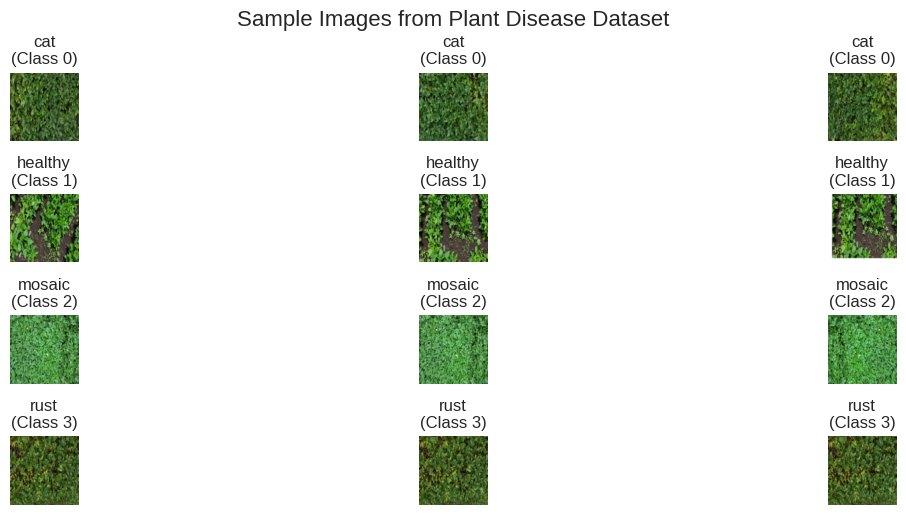

Sample images from your plant disease dataset:
Classes: cat, healthy, mosaic, rust
Image size: 128x128 pixels
Total images: 96
Training images: 76 (80%)
Validation images: 10 (10%)
Test images: 10 (10%)

Memory-efficient loading:
- Images are loaded on-demand during training
- Batch size reduced to 16 for 128x128 images
- Using 2 worker processes for data loading


In [9]:
# Visualize Sample Images from the Dataset
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Get sample images from the dataset
def get_sample_images(dataset, class_names, samples_per_class=3):
    """Get sample images from each class"""
    class_samples = {i: [] for i in range(len(class_names))}
    
    # Collect samples from each class
    for idx, (img_path, class_idx) in enumerate(dataset.samples):
        if len(class_samples[class_idx]) < samples_per_class:
            class_samples[class_idx].append(idx)
        
        # Check if we have enough samples for all classes
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            break
    
    return class_samples

# Get sample indices
sample_indices = get_sample_images(full_dataset, class_names, samples_per_class=3)

# Display sample images from each class
plt.figure(figsize=(15, 5))

for class_idx, class_name in enumerate(class_names):
    indices = sample_indices[class_idx]
    
    for i, sample_idx in enumerate(indices):
        plt.subplot(len(class_names), 3, class_idx * 3 + i + 1)
        
        # Load and process single image
        img, label = full_dataset[sample_idx]
        
        # Denormalize image
        img_denorm = denormalize_image(img)
        img_denorm = torch.clamp(img_denorm, 0, 1)  # Ensure values are in [0,1]
        
        # Convert to numpy and transpose for matplotlib
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f"{class_name}\n(Class {class_idx})")
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Plant Disease Dataset', y=1.02, fontsize=16)
plt.show()

print(f"Sample images from your plant disease dataset:")
print(f"Classes: {', '.join(class_names)}")
print(f"Image size: 128x128 pixels")
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)} (80%)")
print(f"Validation images: {len(val_dataset)} (10%)")
print(f"Test images: {len(test_dataset)} (10%)")

# Memory usage info
print(f"\nMemory-efficient loading:")
print(f"- Images are loaded on-demand during training")
print(f"- Batch size reduced to {batch_size} for 128x128 images")
print(f"- Using {train_loader.num_workers} worker processes for data loading")

In [10]:
# Initialize and Train the BNN Model
# Model parameters
input_size = 3 * 128 * 128  # 128x128 RGB images
hidden_size = 512
num_classes = len(class_names)  # Dynamic based on actual dataset

print(f"Model Configuration:")
print(f"  Input size: {input_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")

# Initialize model
model = BinaryNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device)

# Print model architecture
print("\nBinary Neural Network Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Train the model with enhanced tracking and early stopping
print("\nStarting enhanced training with detailed metrics and early stopping...")
train_losses, train_accuracies, val_losses, val_accuracies, training_history, epoch_times, early_stopped = train_bnn(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    patience=20,  # Stop if no improvement for 5 epochs
    min_delta=0.001  # Minimum improvement threshold
)

Model Configuration:
  Input size: 49152
  Hidden size: 512
  Number of classes: 4
  Classes: ['cat', 'healthy', 'mosaic', 'rust']

Binary Neural Network Architecture:
BinaryNeuralNetwork(
  (input_layer): Linear(in_features=49152, out_features=512, bias=True)
  (hidden_layer): BinaryLinear(in_features=512, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 25,431,044
Trainable parameters: 25,431,044

Starting enhanced training with detailed metrics and early stopping...
Starting training for up to 5 epochs with early stopping (patience=20)...
------------------------------------------------------------

Binary Neural Network Architecture:
BinaryNeuralNetwork(
  (input_layer): Linear(in_features=49152, out_features=512, bias=True)
  (hidden_layer): BinaryLinear(in_features=512, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=4, bias=True)
  


Evaluating model with detailed metrics...


Test Loss: 0.5807, Test Accuracy: 70.00%


/home/bruh/Documents/drone-crop/ML/venv1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bruh/Documents/drone-crop/ML/venv1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bruh/Documents/drone-crop/ML/venv1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

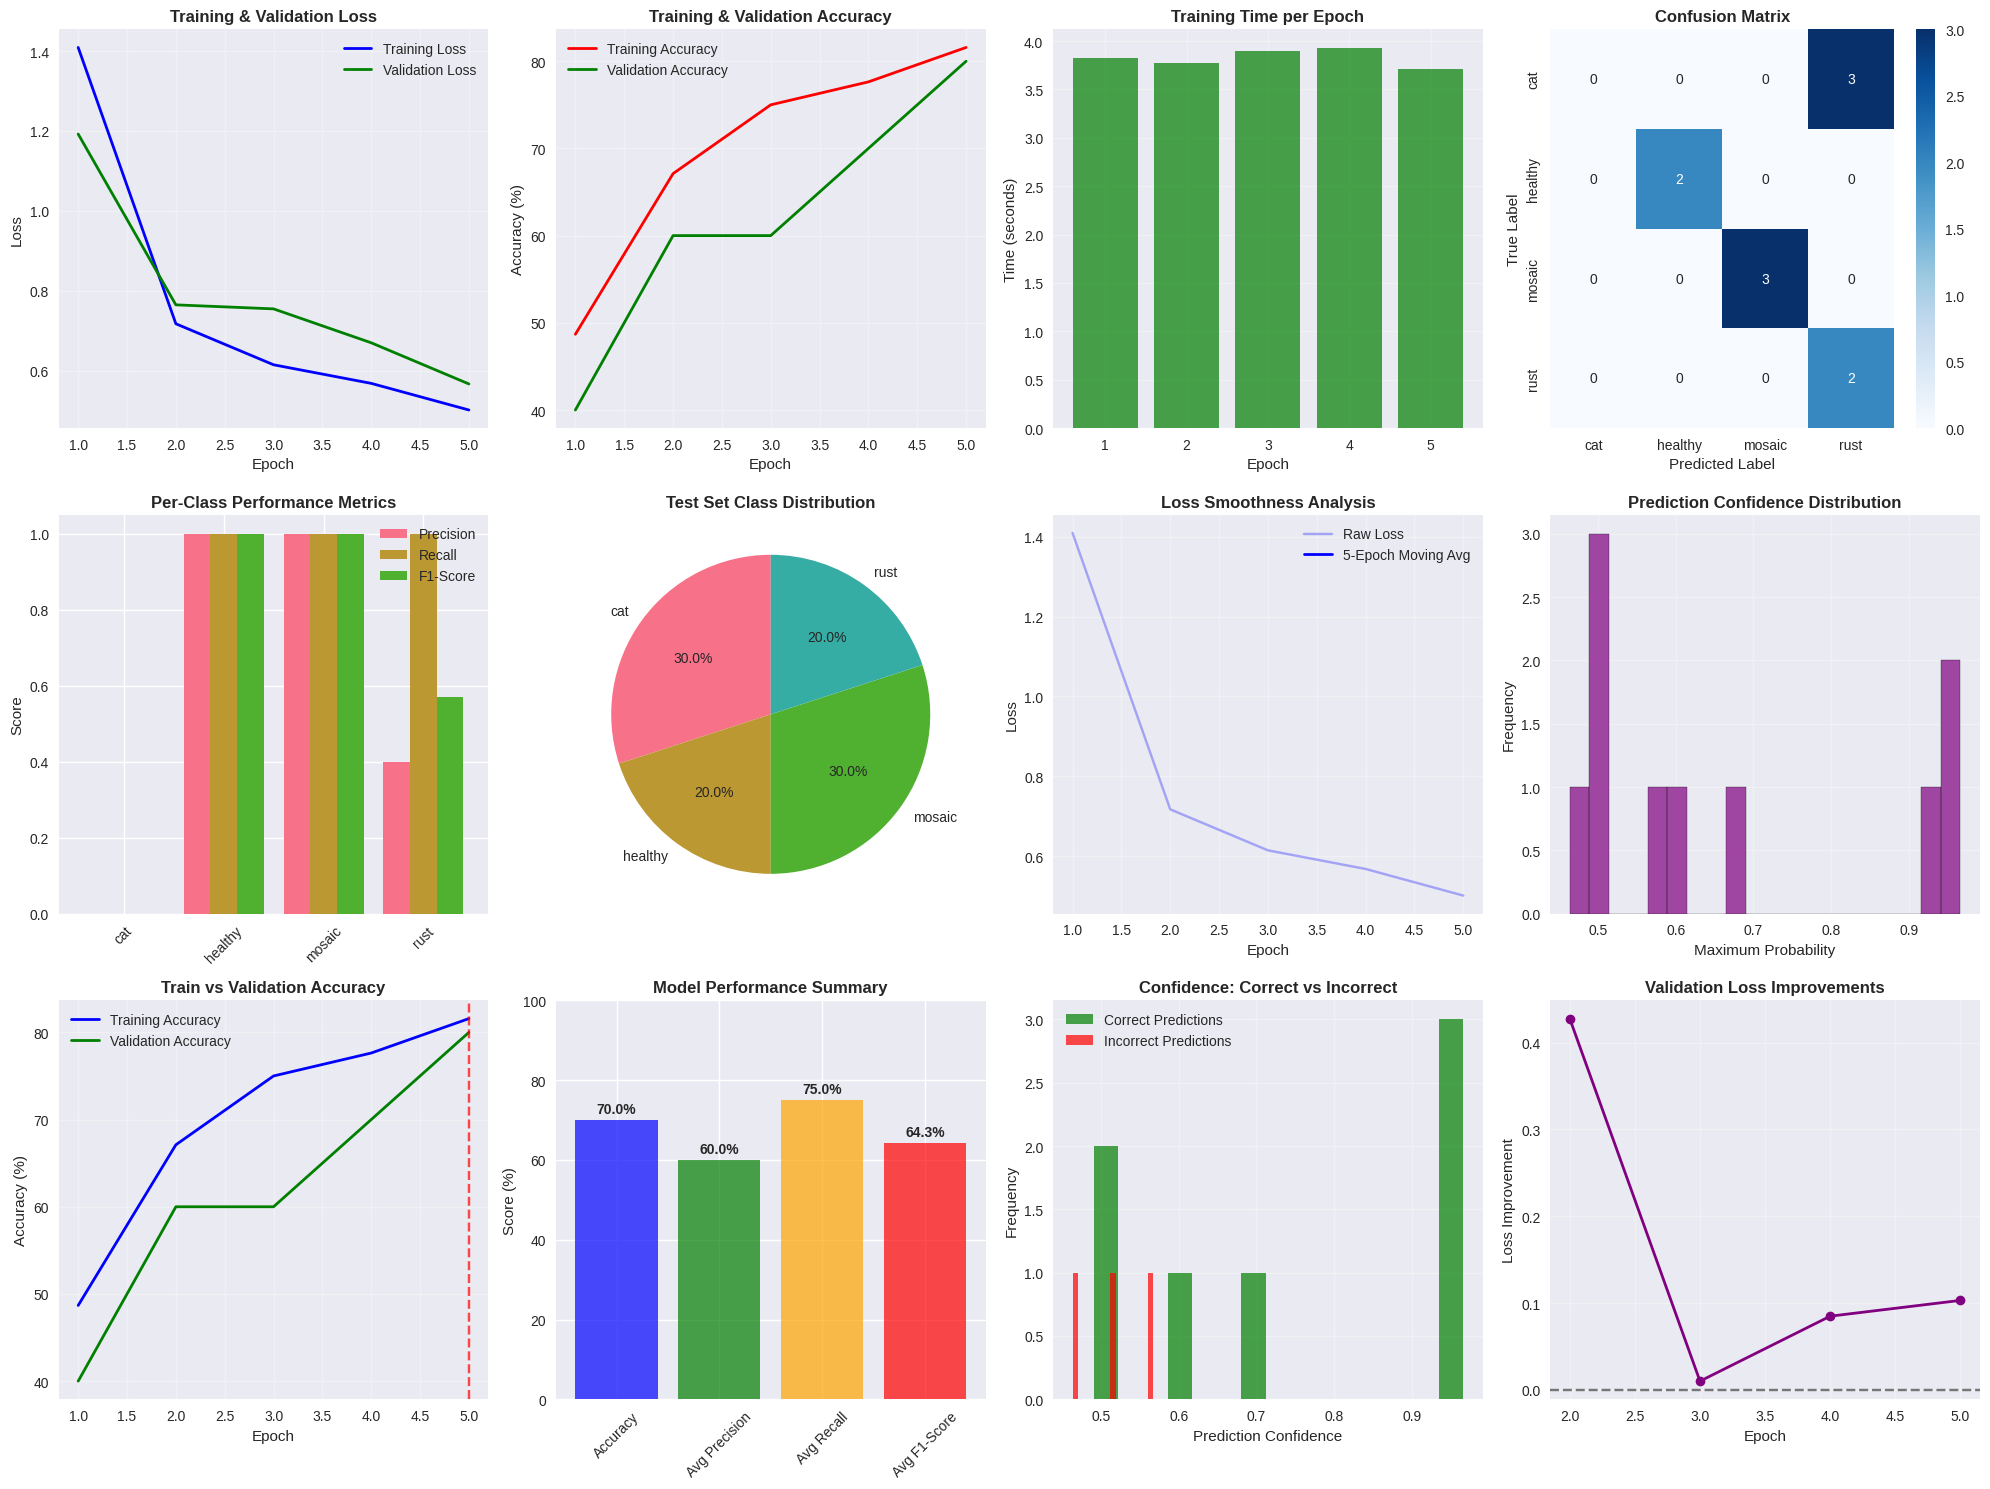


COMPREHENSIVE MODEL PERFORMANCE REPORT
Overall Test Accuracy: 70.00%
Overall Test Loss: 0.5807
Total Training Time: 19.13 seconds
Average Epoch Time: 3.83 seconds

Per-Class Performance:
  cat:
    Precision: 0.000
    Recall: 0.000
    F1-Score: 0.000
    Support: 3
  healthy:
    Precision: 1.000
    Recall: 1.000
    F1-Score: 1.000
    Support: 2
  mosaic:
    Precision: 1.000
    Recall: 1.000
    F1-Score: 1.000
    Support: 3
  rust:
    Precision: 0.400
    Recall: 1.000
    F1-Score: 0.571
    Support: 2

Testing model predictions:

Sample predictions:
Sample 1:
  True label: 1 (healthy)
  Predicted: 1 (healthy)
  Probabilities: [0.22796585 0.4903711  0.06619696 0.21546598]
    cat: 0.228
    healthy: 0.490
    mosaic: 0.066
    rust: 0.215

Sample 2:
  True label: 3 (rust)
  Predicted: 3 (rust)
  Probabilities: [0.2144842  0.09367722 0.00589301 0.6859456 ]
    cat: 0.214
    healthy: 0.094
    mosaic: 0.006
    rust: 0.686

Sample 3:
  True label: 0 (cat)
  Predicted: 3 (rus

In [11]:
# Enhanced Model Evaluation and Comprehensive Visualization
print("\nEvaluating model with detailed metrics...")
detailed_metrics = evaluate_bnn(model, test_loader, criterion, device, class_names)

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Training and Validation Loss
plt.subplot(3, 4, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs, val_losses, 'g-', linewidth=2, label='Validation Loss')
plt.title('Training & Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 4, 2)
plt.plot(epochs, train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'g-', linewidth=2, label='Validation Accuracy')
plt.title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Training Time Analysis
plt.subplot(3, 4, 3)
plt.bar(range(1, len(epoch_times) + 1), epoch_times, alpha=0.7, color='green')
plt.title('Training Time per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
plt.subplot(3, 4, 4)
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Per-Class Performance
plt.subplot(3, 4, 5)
metrics_df = pd.DataFrame({
    'Precision': detailed_metrics['per_class_precision'],
    'Recall': detailed_metrics['per_class_recall'],
    'F1-Score': detailed_metrics['per_class_fscore']
}, index=class_names)

metrics_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# 5. Class Distribution
plt.subplot(3, 4, 6)
class_counts = [sum(1 for label in detailed_metrics['targets'] if label == i) for i in range(len(class_names))]
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution', fontsize=12, fontweight='bold')

# 6. Loss Smoothness (Moving Average)
plt.subplot(3, 4, 7)
window_size = 5
if len(train_losses) >= window_size:
    smoothed_loss = pd.Series(train_losses).rolling(window=window_size).mean()
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.3, label='Raw Loss')
    plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, 'b-', linewidth=2, label=f'{window_size}-Epoch Moving Avg')
    plt.legend()
else:
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Loss Smoothness Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# 7. Prediction Confidence Distribution
plt.subplot(3, 4, 8)
max_probs = [max(prob) for prob in detailed_metrics['probabilities']]
plt.hist(max_probs, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 8. Training vs Validation Accuracy
plt.subplot(3, 4, 9)
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, 'b-', linewidth=2, label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'g-', linewidth=2, label='Validation Accuracy')
plt.axvline(x=val_accuracies.index(max(val_accuracies))+1, color='red', linestyle='--', alpha=0.7)
plt.title('Train vs Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 9. Training Metrics Summary
plt.subplot(3, 4, 10)
summary_metrics = [
    detailed_metrics['test_accuracy'],
    np.mean(detailed_metrics['per_class_precision']) * 100,
    np.mean(detailed_metrics['per_class_recall']) * 100,
    np.mean(detailed_metrics['per_class_fscore']) * 100
]
metric_names = ['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']
bars = plt.bar(metric_names, summary_metrics, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.title('Model Performance Summary', fontsize=12, fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
# Add value labels on bars
for bar, value in zip(bars, summary_metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)

# 10. Error Analysis
plt.subplot(3, 4, 11)
correct_mask = np.array(detailed_metrics['targets']) == np.array(detailed_metrics['predictions'])
correct_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if correct_mask[i]]
incorrect_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if not correct_mask[i]]

plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidences, bins=15, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Validation Loss Improvement and Early Stopping Analysis
plt.subplot(3, 4, 12)
val_loss_improvements = [-1 * (val_losses[i] - val_losses[i-1]) for i in range(1, len(val_losses))]
plt.plot(range(2, len(val_losses) + 1), val_loss_improvements, 'purple', marker='o', linewidth=2)
plt.title('Validation Loss Improvements', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Improvement')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add early stopping marker if applicable
if early_stopped:
    stopped_epoch = len(val_losses)
    plt.axvline(x=stopped_epoch, color='red', linestyle='--', alpha=0.7)
    plt.text(stopped_epoch - 0.5, max(val_loss_improvements)/2, 'Early Stopping', 
             rotation=90, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('results/comprehensive_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
print(f"{'='*60}")
print(f"Overall Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"Overall Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"Total Training Time: {sum(epoch_times):.2f} seconds")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
if early_stopped:
    print(f"Early stopping activated after {len(train_losses)} epochs (patience=5)")
    print(f"Best validation loss: {min(val_losses):.4f} at epoch {val_losses.index(min(val_losses))+1}")
print(f"\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {detailed_metrics['per_class_precision'][i]:.3f}")
    print(f"    Recall: {detailed_metrics['per_class_recall'][i]:.3f}")
    print(f"    F1-Score: {detailed_metrics['per_class_fscore'][i]:.3f}")
    print(f"    Support: {detailed_metrics['per_class_support'][i]}")
print(f"{'='*60}")

# Test model predictions on a few samples
print("\nTesting model predictions:")
model.eval()
with torch.no_grad():
    # Get a small batch from test dataset
    test_iter = iter(test_loader)
    test_batch = next(test_iter)
    test_samples, test_labels = test_batch
    
    # Select just the first 5 samples
    test_samples = test_samples[:5].to(device)
    test_labels = test_labels[:5].to(device)
    
    # Get predictions
    logits = model(test_samples)
    probabilities = F.softmax(logits, dim=1)
    predicted_classes = torch.argmax(logits, dim=1)
    
    print("\nSample predictions:")
    for i in range(min(5, len(test_samples))):
        true_class_name = class_names[test_labels[i].item()]
        pred_class_name = class_names[predicted_classes[i].item()]
        
        print(f"Sample {i+1}:")
        print(f"  True label: {test_labels[i].item()} ({true_class_name})")
        print(f"  Predicted: {predicted_classes[i].item()} ({pred_class_name})")
        print(f"  Probabilities: {probabilities[i].cpu().numpy()}")
        
        # Show probability for each class
        for j, class_name in enumerate(class_names):
            prob = probabilities[i][j].item()
            print(f"    {class_name}: {prob:.3f}")
        print()

In [12]:
# Comprehensive CSV Data Export
print("\nExporting training data to CSV files...")

# 1. Training History CSV
training_df = pd.DataFrame(training_history)
training_df.to_csv('results/training_history.csv', index=False)
print("✓ Training history saved to: results/training_history.csv")

# 2. Detailed Test Results CSV
test_results = []
for i in range(len(detailed_metrics['targets'])):
    test_results.append({
        'sample_id': i,
        'true_label': detailed_metrics['targets'][i],
        'true_class': class_names[detailed_metrics['targets'][i]],
        'predicted_label': detailed_metrics['predictions'][i],
        'predicted_class': class_names[detailed_metrics['predictions'][i]],
        'correct': detailed_metrics['targets'][i] == detailed_metrics['predictions'][i],
        'confidence': max(detailed_metrics['probabilities'][i]),
        **{f'prob_{class_names[j]}': detailed_metrics['probabilities'][i][j] for j in range(len(class_names))}
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('results/test_predictions.csv', index=False)
print("✓ Test predictions saved to: results/test_predictions.csv")

# 3. Per-Class Performance Metrics CSV
per_class_metrics = pd.DataFrame({
    'class_name': class_names,
    'precision': detailed_metrics['per_class_precision'],
    'recall': detailed_metrics['per_class_recall'],
    'f1_score': detailed_metrics['per_class_fscore'],
    'support': detailed_metrics['per_class_support']
})
per_class_metrics.to_csv('results/per_class_metrics.csv', index=False)
print("✓ Per-class metrics saved to: results/per_class_metrics.csv")

# 4. Model Configuration and Final Results CSV
model_summary = {
    'parameter': [
        'model_type', 'input_size', 'hidden_size', 'num_classes',
        'num_epochs', 'batch_size', 'learning_rate', 'optimizer',
        'total_parameters', 'trainable_parameters',
        'final_train_loss', 'final_train_accuracy', 'test_loss', 'test_accuracy',
        'total_training_time', 'avg_epoch_time',
        'dataset_total_samples', 'train_samples', 'val_samples', 'test_samples',
    'early_stopping', 'early_stopping_epoch'
    ],
    'value': [
        'Binary Neural Network', input_size, hidden_size, num_classes,
        40, batch_size, 0.0001, 'Adam',
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
        train_losses[-1], train_accuracies[-1], 
        detailed_metrics['test_loss'], detailed_metrics['test_accuracy'],
        sum(epoch_times), np.mean(epoch_times),
        len(full_dataset), len(train_dataset), len(val_dataset), len(test_dataset),
        'Yes' if early_stopped else 'No', len(train_losses) if early_stopped else 40
    ]
}
model_summary_df = pd.DataFrame(model_summary)
model_summary_df.to_csv('results/model_summary.csv', index=False)
print("✓ Model summary saved to: results/model_summary.csv")

# 5. Confusion Matrix CSV
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
cm_df = pd.DataFrame(cm, index=[f'True_{name}' for name in class_names], 
                     columns=[f'Pred_{name}' for name in class_names])
cm_df.to_csv('results/confusion_matrix.csv')
print("✓ Confusion matrix saved to: results/confusion_matrix.csv")

# 6. Training Progress Summary CSV with Validation Data
epoch_summary = []
for i in range(len(train_losses)):
    epoch_summary.append({
        'epoch': i + 1,
        'train_loss': train_losses[i],
        'train_accuracy': train_accuracies[i],
        'val_loss': val_losses[i],
        'val_accuracy': val_accuracies[i],
        'epoch_time': epoch_times[i],
        'cumulative_time': sum(epoch_times[:i+1]),
        'train_loss_improvement': 0 if i == 0 else train_losses[i-1] - train_losses[i],
        'val_loss_improvement': 0 if i == 0 else val_losses[i-1] - val_losses[i],
        'is_best_model': val_losses[i] == min(val_losses[:i+1])
    })

epoch_summary_df = pd.DataFrame(epoch_summary)
epoch_summary_df.to_csv('results/epoch_summary.csv', index=False)
print("✓ Epoch summary saved to: results/epoch_summary.csv")

# 7. Binary Weights Analysis CSV with Early Stopping Info
with torch.no_grad():
    hidden_weights = model.hidden_layer.weight.data.cpu().numpy()
    binary_weights = np.sign(hidden_weights)
    
    weights_analysis = {
        'layer': ['hidden_layer'],
        'total_weights': [hidden_weights.size],
        'positive_weights': [np.sum(binary_weights > 0)],
        'negative_weights': [np.sum(binary_weights < 0)],
        'zero_weights': [np.sum(binary_weights == 0)],
        'weight_mean': [np.mean(hidden_weights)],
        'weight_std': [np.std(hidden_weights)],
        'binary_weight_ratio': [np.sum(binary_weights > 0) / hidden_weights.size],
        'early_stopping_active': ['Yes' if early_stopped else 'No'],
        'completed_epochs': [len(train_losses)],
        'best_val_loss_epoch': [val_losses.index(min(val_losses)) + 1]
    }
    
weights_analysis_df = pd.DataFrame(weights_analysis)
weights_analysis_df.to_csv('results/binary_weights_analysis.csv', index=False)
print("✓ Binary weights analysis saved to: results/binary_weights_analysis.csv")

# 8. Dataset Statistics CSV with Train/Val/Test Split
# Convert labels to numpy arrays for consistent handling
def ensure_numpy_array(labels):
    """Convert labels to numpy arrays regardless of input type (list, tensor, etc.)"""
    if isinstance(labels, torch.Tensor):
        return labels.cpu().numpy()
    elif isinstance(labels, np.ndarray):
        return labels
    else:
        return np.array(labels)

# Convert all label sets to numpy arrays
train_labels_np = ensure_numpy_array(train_labels)
val_labels_np = ensure_numpy_array(val_labels)
test_labels_np = ensure_numpy_array(test_labels)

dataset_stats = []
for i, class_name in enumerate(class_names):
    # Count occurrences using numpy
    train_count = np.sum(train_labels_np == i)
    val_count = np.sum(val_labels_np == i)
    test_count = np.sum(test_labels_np == i)
    total_count = train_count + val_count + test_count
    
    dataset_stats.append({
        'class_name': class_name,
        'class_id': i,
        'train_samples': int(train_count),  # Convert to int to avoid numpy type issues
        'val_samples': int(val_count),
        'test_samples': int(test_count),
        'total_samples': int(total_count),
        'train_percentage': (train_count / len(train_labels_np)) * 100,
        'val_percentage': (val_count / len(val_labels_np)) * 100,
        'test_percentage': (test_count / len(test_labels_np)) * 100,
        'overall_percentage': (total_count / len(full_dataset)) * 100
    })

dataset_stats_df = pd.DataFrame(dataset_stats)
dataset_stats_df.to_csv('results/dataset_statistics.csv', index=False)
print("✓ Dataset statistics saved to: results/dataset_statistics.csv")

# Create a comprehensive summary report
print(f"\n{'='*80}")
print("CSV FILES EXPORTED SUCCESSFULLY")
print(f"{'='*80}")
print("The following CSV files have been created in the 'results/' directory:")
print("1. training_history.csv - Detailed epoch-by-epoch training metrics")
print("2. test_predictions.csv - Individual test sample predictions and probabilities")
print("3. per_class_metrics.csv - Precision, recall, F1-score for each class")
print("4. model_summary.csv - Model configuration and final performance")
print("5. confusion_matrix.csv - Confusion matrix data")
print("6. epoch_summary.csv - Training and validation progress with improvements")
print("7. binary_weights_analysis.csv - Analysis of binary weight distribution with early stopping info")
print("8. dataset_statistics.csv - Dataset composition and train/val/test distribution")
print(f"{'='*80}")

# Display sample of key CSV files
print("\nSample of Training History:")
print(training_df.head())
print("\nSample of Test Predictions:")
print(test_results_df.head())
print("\nPer-Class Metrics:")
print(per_class_metrics)


Exporting training data to CSV files...
✓ Training history saved to: results/training_history.csv
✓ Test predictions saved to: results/test_predictions.csv
✓ Per-class metrics saved to: results/per_class_metrics.csv
✓ Model summary saved to: results/model_summary.csv
✓ Confusion matrix saved to: results/confusion_matrix.csv
✓ Epoch summary saved to: results/epoch_summary.csv
✓ Binary weights analysis saved to: results/binary_weights_analysis.csv
✓ Dataset statistics saved to: results/dataset_statistics.csv

CSV FILES EXPORTED SUCCESSFULLY
The following CSV files have been created in the 'results/' directory:
1. training_history.csv - Detailed epoch-by-epoch training metrics
2. test_predictions.csv - Individual test sample predictions and probabilities
3. per_class_metrics.csv - Precision, recall, F1-score for each class
4. model_summary.csv - Model configuration and final performance
5. confusion_matrix.csv - Confusion matrix data
6. epoch_summary.csv - Training and validation progres

In [13]:
# Final performance summary
print(f"\n{'='*80}")
print("FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Model: Binary Neural Network for Plant Disease Classification")
print(f"Dataset: {len(class_names)} classes - {', '.join(class_names)}")
print(f"Total Images: {len(full_dataset)} (Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)})")
print(f"Image Size: 128x128 RGB")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Max Training Epochs: 40")
print(f"Actual Epochs Run: {len(train_losses)}")
print(f"Early Stopping: {'Activated' if early_stopped else 'Not triggered'}")
print(f"Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
print(f"Training Time: {sum(epoch_times):.2f} seconds")
print(f"")
print(f"FINAL RESULTS:")
print(f"  Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"  Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"  Average Precision: {np.mean(detailed_metrics['per_class_precision']):.3f}")
print(f"  Average Recall: {np.mean(detailed_metrics['per_class_recall']):.3f}")
print(f"  Average F1-Score: {np.mean(detailed_metrics['per_class_fscore']):.3f}")
print(f"")
print(f"MODEL COMPRESSION:")
binary_params = sum(p.numel() for name, p in model.named_parameters() if 'hidden_layer.weight' in name)
total_params = sum(p.numel() for p in model.parameters())
print(f"  Binary Parameters: {binary_params:,} ({binary_params/total_params:.1%} of total)")
print(f"  Theoretical Storage Reduction: ~{binary_params * 32 / total_params:.1f}x for binary weights")
print(f"{'='*80}")
print("All results, graphs, and CSV files have been saved to the 'results/' directory.")
print(f"{'='*80}")


FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY
Model: Binary Neural Network for Plant Disease Classification
Dataset: 4 classes - cat, healthy, mosaic, rust
Total Images: 96 (Train: 76, Val: 10, Test: 10)
Image Size: 128x128 RGB
Model Parameters: 25,431,044
Max Training Epochs: 40
Actual Epochs Run: 5
Early Stopping: Not triggered
Best Validation Loss: 0.5667 (Epoch 5)
Training Time: 19.13 seconds

FINAL RESULTS:
  Test Accuracy: 70.00%
  Test Loss: 0.5807
  Average Precision: 0.600
  Average Recall: 0.750
  Average F1-Score: 0.643

MODEL COMPRESSION:
  Binary Parameters: 262,144 (1.0% of total)
  Theoretical Storage Reduction: ~0.3x for binary weights
All results, graphs, and CSV files have been saved to the 'results/' directory.


Binary Weights Analysis:
Hidden layer weights shape: torch.Size([512, 512])
Original weights - Mean: -0.0001, Std: 0.0979
Binary weights - Unique values: tensor([-1.,  1.], device='cuda:0')
Binary weights - Distribution: +1: 131126, -1: 131018


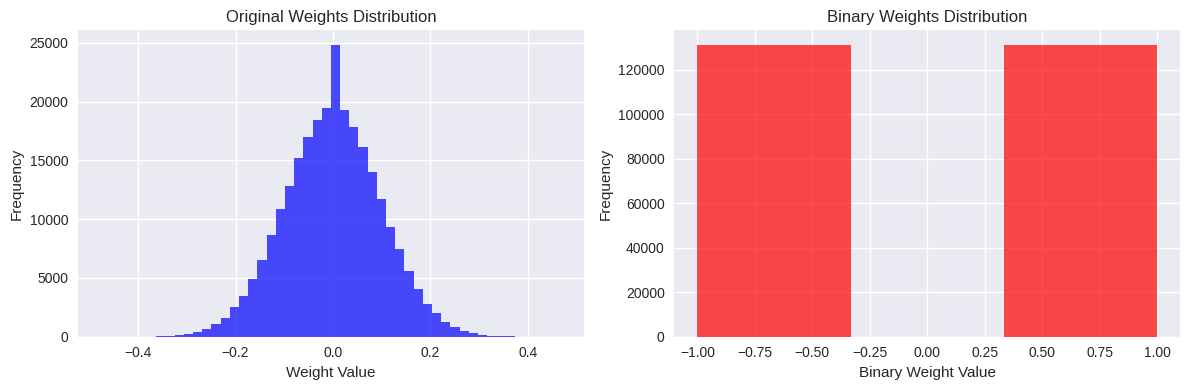


Model Compression Analysis:
Total parameters: 25,431,044
Binary parameters: 262,144
Binary ratio: 1.03%
Theoretical storage compression: 0.0x


In [14]:
# Model Analysis and Binary Weights Visualization
def analyze_binary_weights(model):
    """Analyze the binary weights in the model"""
    print("Binary Weights Analysis:")
    print("=" * 50)
    
    # Analyze hidden layer binary weights
    with torch.no_grad():
        hidden_weights = model.hidden_layer.weight
        binary_weights = torch.sign(hidden_weights)
        
        print(f"Hidden layer weights shape: {hidden_weights.shape}")
        print(f"Original weights - Mean: {hidden_weights.mean():.4f}, Std: {hidden_weights.std():.4f}")
        print(f"Binary weights - Unique values: {torch.unique(binary_weights)}")
        print(f"Binary weights - Distribution: +1: {(binary_weights == 1).sum().item()}, -1: {(binary_weights == -1).sum().item()}")
        
        # Plot weight distributions
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(hidden_weights.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue')
        plt.title('Original Weights Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.hist(binary_weights.cpu().numpy().flatten(), bins=3, alpha=0.7, color='red')
        plt.title('Binary Weights Distribution')
        plt.xlabel('Binary Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Analyze the trained model
analyze_binary_weights(model)

# Calculate model size reduction
def calculate_model_compression():
    """Calculate the compression achieved by using binary weights"""
    
    # Count parameters in binary layers
    binary_params = sum(p.numel() for name, p in model.named_parameters() 
                       if 'hidden_layer.weight' in name)
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\nModel Compression Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Binary parameters: {binary_params:,}")
    print(f"Binary ratio: {binary_params/total_params:.2%}")
    
    # In practice, binary weights can be stored using 1 bit vs 32 bits (float32)
    # This gives approximately 32x compression for binary weights
    theoretical_compression = binary_params * 32 / (total_params * 32 - binary_params * 31)
    print(f"Theoretical storage compression: {theoretical_compression:.1f}x")

calculate_model_compression()

## Using Real Plant Disease Data

To use this BNN with real plant disease images, follow these steps:

### 1. Data Preparation
```python
# Example for loading real plant disease dataset
from torchvision import datasets, transforms
from PIL import Image

# Define transforms for 128x128 RGB images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load your dataset (example structure)
# dataset/
#   ├── healthy/
#   ├── disease1/
#   └── disease2/

dataset = datasets.ImageFolder(root='path/to/your/dataset', 
                              transform=transform)
```

### 2. Model Adaptation
- Adjust `num_classes` parameter based on your dataset
- Modify `hidden_size` for different model complexities
- Consider adding more binary layers for deeper networks
- Note: 128x128 images require 4x more parameters than 64x64 (49,152 vs 12,288 input features)

### 3. Training Tips
- Use data augmentation for better generalization
- Implement learning rate scheduling
- Add early stopping to prevent overfitting
- Consider using batch normalization before binary activations
- Higher resolution images may require longer training times

### 4. Performance Optimization
- Experiment with different optimizers (SGD, AdamW)
- Try different initialization strategies for binary weights
- Implement gradient clipping for stable training
- Use mixed precision training for faster computation
- Consider reducing batch size for 128x128 images if memory is limited